# Word2vec only with one matrix

Choose CBOW/Skip-Gram again. Implement it, but now without second `h_dim x vocab_size` matrix. Remember what was the loss function in Stanford lecture.

$$ L = - \frac{1}{T} \sum_{t=1}^T \sum_{-m <= j <= m, j \ne 0} log P(w_{t+j}|w_{t+j-m})$$


$$ P(w_h | w_i) = \frac{exp(s(v_i, v_h))}{\sum exp(s(v_i, v_w))}$$

Where $s(x, y)$ is a similarity function. It is common to use dot-product here $s(x, y) = s^Ty$. The sum in the denominator is across all vocabulary for $P$ to be a probability distribution.

Look to this formula closer. There is no projection back to vocabulary dimension in the loss! So, we can reduce the number of parameters by the factor of two by not using the second matrix $W'$. Your new task is to code CBOW / SkipGram with this loss.

**Main idea:**

We project word vectors to some space. Next, we work with the space itself. We update projection matrix weights so that similar (in the terms of Distributional semantics) words have similar vectors in that space. We don't need to solve classification task explicitly here.

**Tip:**

Work with matrix operations and not with nn.layers / keras.layers.

**Results of this task** (the very same as in task 3):
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies


**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)



Supplementary materials:
  * [cs224n winter 2017 lecture 2 video](https://www.youtube.com/watch?v=ERibwqs9p38&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6&index=2)
  * [cs224n winter 2019 lecture 1 slides](http://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture01-wordvecs1.pdf)

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

### Подготовка данных

Будем использовать дефолтный текст ('text8'). Повторим простую предобработку текста из задания 2: удалим из текста стопслова и слишком редкие слова (встречающиеся менее 25 раз).
Также создадим батчер для SkipGram модели. Он генерирует батчи, состоящие из n пар слов (x, y), где x - центрально еслово, y - некоторое слово из окна вокруг центрального слова.

In [2]:
from preprocessing import prepare_data
frequent_words, token2id, id2token, batcher = prepare_data(min_count=25, shuffle=False)
print(f'Vocab size: {len(token2id)}')

Vocab size: 27790


### Модель

Почти то же самое, что и в задании 3, но здесь используем только одну матрицу, содержащиеся в которой вектора теперь, по сути, являются одновременно и эмбеддингами, и весами софтмакса, что в два раза уменьшает количество обучаемых параметров.

In [3]:
class Word2VecOneMatrixModel():
    def __init__(self, params):
        self.embeddings = tf.get_variable(name='embedding_matrix', 
                                          shape=[params['vocab_size'], params['embedding_dim']], 
                                          dtype=tf.float32, 
                                          trainable=True)
        
        self.inputs = tf.placeholder(shape=(None), dtype=tf.int32, name='inputs')
        self.targets = tf.placeholder(shape=(None), dtype=tf.int32, name='targets')
        self.learning_rate = tf.placeholder(shape=[], dtype=tf.float32, name='learning_rate')
        
        self.inputs_embedded = tf.nn.embedding_lookup(self.embeddings, self.inputs)
        self.logits = self.inputs_embedded @ tf.transpose(self.embeddings, perm=[1, 0])
        self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.targets, logits=self.logits))
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.train.get_global_step())
        
        self.loss_history = []
    
    def train(self, session, inputs, targets, learning_rate):
        feed_dict = {
            self.inputs: inputs, 
            self.targets: targets,
            self.learning_rate: learning_rate,
        }
    
        loss, _ = session.run([self.loss, self.train_op], feed_dict=feed_dict)
        
        return loss


In [4]:
def train_model(model, session, batcher, batch_size, num_epochs, learning_rate, loss_history, print_every=100):
    train_iter = int(np.ceil(len(batcher.data) / batch_size))
    print('Start training... \n')
    
    for epoch in range(1, num_epochs + 1):
        batcher.shuffle()
        
        print(f'Epoch {epoch}/{num_epochs}:')        
        epoch_loss = 0
        intermediate_loss = 0
        
        for i, (inputs, targets) in enumerate(batcher.generate_batches(batch_size=batch_size), 1):
            current_loss = model.train(session=session, 
                                        inputs=inputs, 
                                        targets=targets, 
                                        learning_rate=learning_rate)
            
            epoch_loss += current_loss
            intermediate_loss += current_loss
            loss_history.append(current_loss)
            
            if i % print_every == 0 or (i == 1 and epoch == 1) or i == train_iter:
                if i == 1:
                    div = 1
                elif i == train_iter:
                    div = train_iter % print_every
                else:
                    div = print_every
                print(f'Epoch: [{epoch}/{num_epochs}], step: [{i}/{train_iter}], mean loss: {intermediate_loss / div}')
                if i != 1:
                    intermediate_loss = 0
        
        print(f'Epoch {epoch} finished, mean loss during epoch {epoch}: {epoch_loss / train_iter} \n')
    
    print('...training finished.')

In [5]:
def plot_loss(losses, average_over_batches=1, upper_bound=None):
    average_losses = [np.mean(losses[i:i+average_over_batches+1]) for i in range(0, len(losses), average_over_batches)]
    indices = list(range(average_over_batches, len(losses), average_over_batches)) + [len(losses)]
    plt.plot(indices, average_losses, '-')
    plt.grid(True)
    plt.title('Training loss')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    if upper_bound is not None:
        plt.ylim(top=upper_bound)
    plt.show()

### Обучение

Обучим word2vewc модель с эмбеддингами размерности 50.

In [6]:
params = {
    'embedding_dim': 50, 
    'vocab_size': len(token2id)
}

In [7]:
tf.reset_default_graph()
np.random.seed(111)
tf.set_random_seed(111)

In [8]:
model = Word2VecOneMatrixModel(params)

In [9]:
%%time

session = tf.Session()
session.run(tf.global_variables_initializer())

train_model(model=model, 
            session=session, 
            batcher=batcher, 
            num_epochs=3, 
            batch_size=2048, 
            learning_rate=1e-3, 
            loss_history=model.loss_history, 
            print_every=3000)

Start training... 

Epoch 1/3:
Epoch: [1/3], step: [1/29334], mean loss: 10.2323637008667
Epoch: [1/3], step: [3000/29334], mean loss: 8.5521854651769
Epoch: [1/3], step: [6000/29334], mean loss: 8.145368762334188
Epoch: [1/3], step: [9000/29334], mean loss: 7.987194353898366
Epoch: [1/3], step: [12000/29334], mean loss: 7.896067735513052
Epoch: [1/3], step: [15000/29334], mean loss: 7.838114939371745
Epoch: [1/3], step: [18000/29334], mean loss: 7.799350554784139
Epoch: [1/3], step: [21000/29334], mean loss: 7.769369471391042
Epoch: [1/3], step: [24000/29334], mean loss: 7.747208862622579
Epoch: [1/3], step: [27000/29334], mean loss: 7.729189150333404
Epoch: [1/3], step: [29334/29334], mean loss: 7.718738039845366
Epoch 1 finished, mean loss during epoch 1: 7.922809111313675 

Epoch 2/3:
Epoch: [2/3], step: [3000/29334], mean loss: 7.697992171128591
Epoch: [2/3], step: [6000/29334], mean loss: 7.6918893791834515
Epoch: [2/3], step: [9000/29334], mean loss: 7.686724006493886
Epoch: [2/

Обучение в течение трех эпох заняло чуть больше часа на GTX 1050 Ti. Столько же времени заняло обучение модели из предыдущего задания. Динамика лосса тоже приблизительно такая же, как и в предыдущем задании.

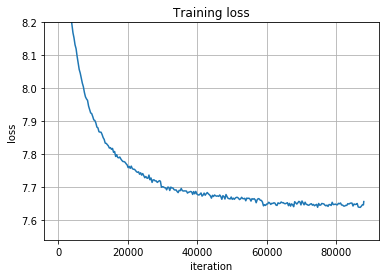

In [10]:
plot_loss(model.loss_history, average_over_batches=300, upper_bound=8.2)

In [12]:
embeddings = session.run(model.embeddings)
session.close()

### Оценка качества эмбеддингов

In [15]:
def get_embedding(token):
    '''Returns embedding for given token.'''
    
    return embeddings[token2id[token]]

def most_similar_to_embedding(input_embedding, embeddings, num_neighbors=10):
    '''Returns embeddings closest to given embedding measured by cosine similarity.'''
    
    distances = cosine_similarity(embeddings, input_embedding.reshape(1, -1)).reshape(-1)
    neighbor_indices = np.argpartition(distances, -num_neighbors-1)[-num_neighbors-1:]
    sorted_neighbor_indices = list(reversed(neighbor_indices[np.argsort(distances[neighbor_indices])]))
    return [id2token[idx] for idx in sorted_neighbor_indices[1:]]

def most_similar_to_token(token, embeddings, num_neighbors=10):
    '''Returns embeddings closest to embedding of given token measured by cosine similarity.'''
    
    return  most_similar_to_embedding(get_embedding(token), embeddings, num_neighbors)


Найдем самые близкие по косинусному расстоянию между эмбеддингами слова для слов fly, car, earth, computer, machine.

In [16]:
most_similar_to_token('fly', embeddings)

['airplane',
 'flying',
 'pilots',
 'flight',
 'pilot',
 'crew',
 'ground',
 'catch',
 'safely',
 'flies']

In [17]:
most_similar_to_token('car', embeddings)

['driver',
 'cars',
 'truck',
 'racing',
 'crash',
 'race',
 'raced',
 'motorcycle',
 'accident',
 'automobile']

In [18]:
most_similar_to_token('earth', embeddings)

['moon',
 'planet',
 'orbit',
 'sun',
 'surface',
 'planets',
 'atmosphere',
 'shadow',
 'explained',
 'observing']

In [20]:
most_similar_to_token('computer', embeddings)

['computers',
 'hardware',
 'computing',
 'systems',
 'software',
 'machines',
 'devices',
 'technology',
 'graphics',
 'programs']

In [21]:
most_similar_to_token('machine', embeddings)

['machines',
 'gun',
 'turing',
 'guns',
 'using',
 'designed',
 'internally',
 'virtual',
 'computer',
 'automatic']

Почти все полученные ближайшие соседи являются адекватными по смыслу.

Теперь попробуем получить корректные аналогии.

In [27]:
input_embedding = get_embedding('king') - get_embedding('man') + get_embedding('woman')
most_similar_to_embedding(input_embedding, embeddings)

['daughter',
 'wife',
 'son',
 'henry',
 'marries',
 'married',
 'vii',
 'iii',
 'husband',
 'wed']

Классический пример с king - man + woman не сработал. Ничего похожего на queen среди ближайших соседей нет.

Однако, неокторые другие аналогии работают:

In [28]:
input_embedding = get_embedding('airplane') - get_embedding('pilot') + get_embedding('driver')
most_similar_to_embedding(input_embedding, embeddings)

['car',
 'race',
 'motorcycle',
 'cars',
 'bicycle',
 'cyclist',
 'automobile',
 'taxi',
 'racer',
 'drivers']

airplane - pilot + driver = car

In [31]:
input_embedding = get_embedding('ball') - get_embedding('football') + get_embedding('hockey')
most_similar_to_embedding(input_embedding, embeddings)

['stick',
 'puck',
 'cue',
 'ice',
 'balls',
 'rink',
 'catching',
 'throwing',
 'sticks',
 'thrown']

ball - football + hockey = stick & puck

In [32]:
input_embedding = get_embedding('football') - get_embedding('europe') + get_embedding('america')
most_similar_to_embedding(input_embedding, embeddings)

['soccer',
 'basketball',
 'club',
 'rugby',
 'team',
 'baseball',
 'league',
 'player',
 'association',
 'canadian']

football - europe + america = soccer

Теперь выберем побольше слов и визуализируем их векторные представления с помощью t-SNE.

In [44]:
test_words = ['one', 'two', 'three', 'four', 'five', 
              'russia', 'germany', 'france', 'england', 'scotland', 'britain', 'china', 'japan', 'korea', 'india', 
              'moscow', 'berlin', 'paris', 'london', 'edinburgh',
              'car', 'truck', 'bus', 'train', 'airplane', 'plane', 'ship', 'yacht', 
              'human', 'man', 'woman', 'husband', 'wife', 'parents', 'son', 'daughter', 
              'good', 'great', 'fantastic', 'bad', 'awful', 
              'walk', 'run', 'swim', 'fly', 
              'game', 'sport', 'soccer', 'football', 'basketball', 'hockey', 'tennis', 
              'music', 'song', 'guitar', 'guitarist', 'drums', 'drummer', 'singer', 'vocalist', 
              'rock', 'metal', 'punk', 'rap', 'jazz', 'blues', 'pop', 
              'north', 'south', 'east', 'west']

test_word_embeddings = np.array([get_embedding(word) for word in test_words])
distance_matrix = 1 - np.round(cosine_similarity(test_word_embeddings), decimals=4)

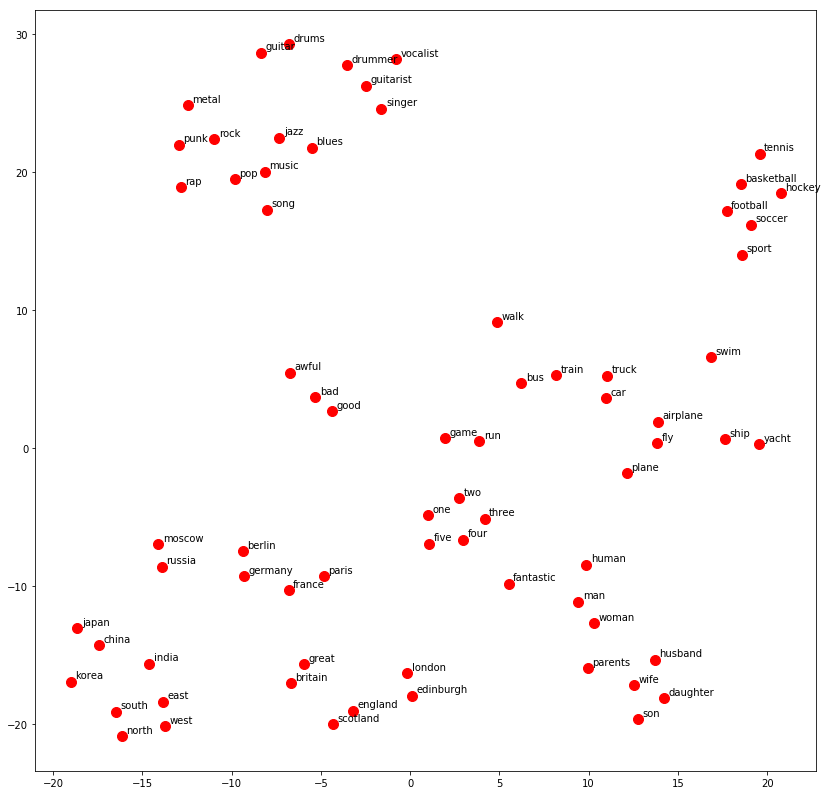

In [45]:
tsne = TSNE(perplexity=10, 
            early_exaggeration=10, 
            learning_rate=20, 
            n_iter=2000, 
            metric='precomputed', 
            method='exact', 
            random_state=100)

points = tsne.fit_transform(distance_matrix)

plt.figure(figsize=[14, 14])
plt.scatter(points[:, 0], points[:, 1], color='red', s=100)

indent = 0.25
for i in range(len(test_words)):
    coords = (points[i, 0] + indent, points[i, 1] + indent)
    plt.annotate(test_words[i], coords)

plt.show()

На визуализации слова разделились на ярко выраженные кластеры близких по смыслу слов: музыка, спорт, числа, страны и столицы...

В целом, можно сделать вывод, что полученные векторные представления действительно содержат семантическую и синтаксическую информацию о словах. Полученные результаты также довольно близки к результатам из предыдущего задания.

In [46]:
with open('embeddings_task4.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle)